### 區塊 1: 環境設定與函式庫導入
說明: 建立一個乾淨的 Python 虛擬環境並安裝所需套件。

1. 建立資料夾並進入 (如果尚未建立):
mkdir aicup-final-project
cd aicup-final-project

2. 建立虛擬環境 (venv):
python -m venv venv

3. 啟用虛擬環境:
(Windows): .\\venv\\Scripts\\activate
(macOS/Linux): source venv/bin/activate

4. 將您的資料檔案放入名為 'data' 的資料夾，然後啟動 Jupyter:
jupyter notebook

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="pastel")
pd.options.display.float_format = '{:.5f}'.format

print("函式庫導入完成。")

函式庫導入完成。


### 區塊 2: config

In [2]:
class CFG:
    DATA_PATH = 'data'
    N_SPLITS = 5
    RANDOM_SEED = 42
    OPTUNA_TRIALS = 30 # Optuna 自動調參的嘗試次數
    
print("專案設定完成。")

專案設定完成。


### 區塊 3: Utility Functions

In [3]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data).sort_values(by=['feature_importance'], ascending=False).head(30)

    plt.figure(figsize=(10, 12))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('LGBM Feature Importance (Top 30)')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

print("工具函式定義完成。")

工具函式定義完成。


### 區塊 4: 資料讀取與預處理

In [4]:
def load_and_preprocess(dir_path):
    print("--- 開始資料讀取與預處理 ---")
    
    # 讀取您的四個檔案
    df_txn = pd.read_csv(os.path.join(dir_path, 'acct_transaction.csv'))
    df_alert = pd.read_csv(os.path.join(dir_path, 'acct_alert.csv'))
    df_predict = pd.read_csv(os.path.join(dir_path, 'acct_predict.csv'))
    submission = pd.read_csv(os.path.join(dir_path, 'submission_template.csv'))

    # 【新增】印出讀取的資料筆數
    print(f"  - 原始交易紀錄筆數: {len(df_txn)}")
    print(f"  - 警示帳戶名單數: {len(df_alert)}")
    print(f"  - 待預測帳戶數: {len(df_predict)}")
    
    # 類別特徵編碼 (Label Encoding)
    print("  - 正在對帳戶ID進行數字編碼...")
    all_accts = pd.concat([df_txn['from_acct'], df_txn['to_acct'], df_alert['acct'], df_predict['acct']]).unique()
    le_acct = LabelEncoder().fit(all_accts)
    
    df_txn['from_acct_id'] = le_acct.transform(df_txn['from_acct'])
    df_txn['to_acct_id'] = le_acct.transform(df_txn['to_acct'])
    df_alert['acct_id'] = le_acct.transform(df_alert['acct'])
    df_predict['acct_id'] = le_acct.transform(df_predict['acct'])

    # 時間特徵轉換
    print("  - 正在轉換時間特徵...")
    time_parts = df_txn['txn_time'].str.split(':', expand=True).astype(int)
    txn_time_seconds = time_parts[0] * 3600 + time_parts[1] * 60 + time_parts[2]
    df_txn['total_seconds'] = df_txn['txn_date'].astype(np.int64) * 86400 + txn_time_seconds.astype(np.int64)

    # 布林/對應特徵轉換
    df_txn['is_self_txn'] = df_txn['is_self_txn'].map({'Y': 1, 'N': 0, 'UNK': 0}).astype(np.int8)

    print("資料預處理完成。")
    return df_txn, df_alert, df_predict, submission, le_acct

### 區塊 5: 探索性資料分析 (EDA)

In [5]:
def perform_eda(df_txn, df_alert):
    print("\n--- 開始探索性資料分析 (EDA) ---")
    
    alert_acct_ids = set(df_alert['acct_id'])
    df_txn['is_alert_acct'] = df_txn['from_acct_id'].isin(alert_acct_ids).astype(int)
    
    # 1. 資料不平衡分析
    total_accts_in_txn = df_txn['from_acct_id'].nunique()
    alert_acct_count = df_alert['acct_id'].nunique()
    non_alert_acct_count = total_accts_in_txn - alert_acct_count
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=['Non-Alert Accounts', 'Alert Accounts'], y=[non_alert_acct_count, alert_acct_count])
    plt.title('Data Imbalance: Number of Accounts in Transaction Data')
    plt.ylabel('Count of Accounts (Log Scale)')
    plt.yscale('log')
    plt.show()
    
    # 2. 交易金額分佈分析 (對數尺度)
    df_txn['log_txn_amt'] = np.log1p(df_txn['txn_amt'])
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df_txn, x='log_txn_amt', hue='is_alert_acct', 
                fill=True, common_norm=False, palette={0: "blue", 1: "red"}, hue_order=[0,1])
    plt.title('Distribution of Transaction Amount (Log Scale) by Account Type')
    plt.xlabel('Log(1 + Transaction Amount)')
    plt.legend(title='Account Type', labels=['Alert', 'Non-Alert'])
    plt.show()
    
    del df_txn['is_alert_acct'], df_txn['log_txn_amt']
    gc.collect()
    
    print("EDA 完成。")

### 區塊 6: 特徵工程

In [6]:
def expert_feature_engineering_by_acct(df_txn, df_acct_dates):
    print(f"開始為 {len(df_acct_dates)} 個帳戶進行特徵工程...")
    
    # --- 1. 時間窗特徵 ---
    print("  - 計算時間窗特徵...")
    df_merged = df_acct_dates.merge(df_txn, left_on='acct_id', right_on='from_acct_id', how='left')
    df_merged = df_merged[df_merged['txn_date'] <= df_merged['date']] # 只保留基準日前的交易
    
    features = df_acct_dates[['acct_id']].copy()
    time_windows = [1, 3, 7, 14, 30]
    
    for days in tqdm(time_windows, desc="計算時間窗特徵"):
        df_window = df_merged[df_merged['txn_date'] > df_merged['date'] - days]
        grp = df_window.groupby('acct_id')
        
        # 金額統計
        amt_stats = grp['txn_amt'].agg(['sum', 'count', 'mean', 'std']).add_prefix(f'send_amt_{days}d_')
        features = features.merge(amt_stats, on='acct_id', how='left')
        
        # 交易對象統計
        unique_to_accts = grp['to_acct_id'].nunique().rename(f'send_to_unique_accts_{days}d')
        features = features.merge(unique_to_accts, on='acct_id', how='left')

    # --- 2. 【新增】全域網路特徵 ---
    print("  - 計算網路特徵...")
    # 計算每個帳戶的總轉出對象數 (out-degree)
    out_degree = df_txn.groupby('from_acct_id')['to_acct_id'].nunique().rename('total_out_degree')
    features = features.merge(out_degree, left_on='acct_id', right_index=True, how='left')
    
    # 計算每個帳戶的總轉入來源數 (in-degree)
    in_degree = df_txn.groupby('to_acct_id')['from_acct_id'].nunique().rename('total_in_degree')
    features = features.merge(in_degree, left_on='acct_id', right_index=True, how='left')
    
    # --- 3. 【新增】行為模式特徵 ---
    print("  - 計算行為模式特徵...")
    # 計算每筆交易距離上一筆交易的時間間隔
    df_txn_sorted = df_txn.sort_values(by=['from_acct_id', 'total_seconds'])
    df_txn_sorted['time_diff'] = df_txn_sorted.groupby('from_acct_id')['total_seconds'].diff()
    
    # 計算時間間隔的統計量
    grp_timediff = df_txn_sorted.groupby('from_acct_id')['time_diff']
    time_diff_features = grp_timediff.agg(['mean', 'std', 'min']).add_prefix('time_diff_')
    features = features.merge(time_diff_features, left_on='acct_id', right_index=True, how='left')

    # --- 4. 最終處理 ---
    features.fillna(0, inplace=True)
    features.replace([np.inf, -np.inf], 0, inplace=True) # 用 0 替換無限大值
    
    print("特徵工程完成。")
    return features

### 區塊 7: main progress - 資料準備與 Optuna 函數定義

--- 開始資料讀取與預處理 ---
  - 原始交易紀錄筆數: 4435890
  - 警示帳戶名單數: 1004
  - 待預測帳戶數: 4780
  - 正在對帳戶ID進行數字編碼...
  - 正在轉換時間特徵...
資料預處理完成。

--- 開始探索性資料分析 (EDA) ---


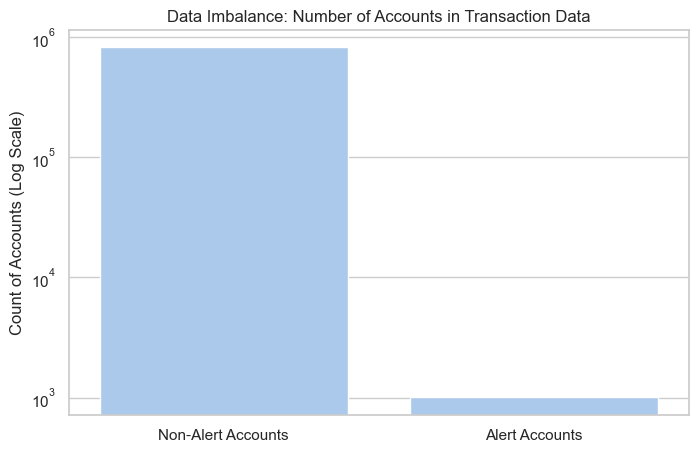

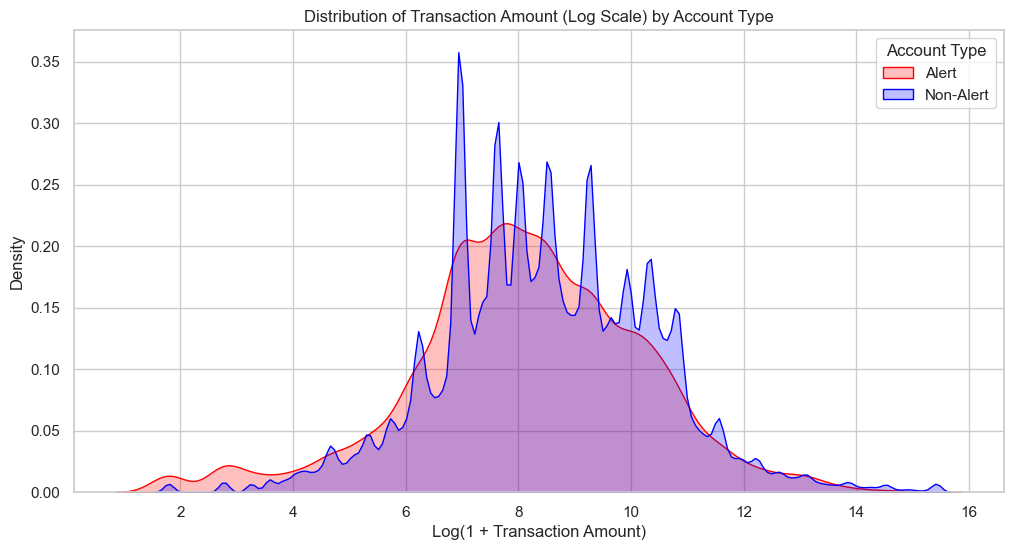

EDA 完成。

--- 準備正、負、測試樣本 ---
開始為 1004 個帳戶進行特徵工程...
  - 計算時間窗特徵...


計算時間窗特徵:   0%|          | 0/5 [00:00<?, ?it/s]

  - 計算網路特徵...
  - 計算行為模式特徵...
特徵工程完成。
開始為 1004 個帳戶進行特徵工程...
  - 計算時間窗特徵...


計算時間窗特徵:   0%|          | 0/5 [00:00<?, ?it/s]

  - 計算網路特徵...
  - 計算行為模式特徵...
特徵工程完成。
開始為 4780 個帳戶進行特徵工程...
  - 計算時間窗特徵...


計算時間窗特徵:   0%|          | 0/5 [00:00<?, ?it/s]

  - 計算網路特徵...
  - 計算行為模式特徵...
特徵工程完成。

最終使用特徵數量: 30
訓練資料維度: (2008, 30)
測試資料維度: (4780, 30)

所有資料準備就緒，Optuna `objective` 函數已定義。


In [14]:
# --- Load and preprocess your data ---
df_txn, df_alert, df_predict, submission, le_acct = load_and_preprocess(CFG.DATA_PATH)

# --- Run EDA ---
perform_eda(df_txn.copy(), df_alert.copy())

# --- Prepare data for feature engineering ---
# --- 修正負樣本來源 ---
print("\n--- 準備正、負、測試樣本 ---")
df_pos_dates = df_alert.rename(columns={'event_date': 'date'})[['acct_id', 'date']]

# 【關鍵修改】從待預測名單中抽樣負樣本
predict_accts_ids = df_predict['acct_id'].unique()
np.random.seed(CFG.RANDOM_SEED)
# 從 4780 個預測帳戶中，抽出約 1004 個當作負樣本
sampled_neg_ids = np.random.choice(predict_accts_ids, size=len(df_alert), replace=False)

df_neg_dates = pd.DataFrame({'acct_id': sampled_neg_ids})
df_neg_dates['date'] = df_txn['txn_date'].max()

# 測試集則用全部的待預測名單
df_test_dates = df_predict[['acct_id']].copy()
df_test_dates['date'] = df_txn['txn_date'].max()

# --- Run feature engineering for the three groups ---
X_pos = expert_feature_engineering_by_acct(df_txn, df_pos_dates)
X_neg = expert_feature_engineering_by_acct(df_txn, df_neg_dates)
X_test = expert_feature_engineering_by_acct(df_txn, df_test_dates)

# --- Prepare data for the model ---
X_pos['label'] = 1
X_neg['label'] = 0
train_df = pd.concat([X_pos, X_neg]).set_index('acct_id').sort_index()

features = [col for col in train_df.columns if col not in ['label', 'date']]
X = train_df[features]
y = train_df['label']
X_test_final = X_test.set_index('acct_id')[features]

print(f"\n最終使用特徵數量: {len(features)}")
print(f"訓練資料維度: {X.shape}")
print(f"測試資料維度: {X_test_final.shape}")

# --- Define the Optuna objective function ---
def objective(trial):
    params = {
        'objective': 'binary', 
        'metric': 'auc',  # <--- 改用 auc
        'n_estimators': 1000,
        'verbosity': -1, 
        'n_jobs': -1, 
        'seed': CFG.RANDOM_SEED,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=CFG.RANDOM_SEED)
    oof_f1 = []
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]  
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]  
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)],
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        
        preds_proba = model.predict_proba(X_valid)[:, 1]
        preds = (preds_proba > 0.15).astype(int)
        oof_f1.append(f1_score(y_valid, preds))
        
    return np.mean(oof_f1)

print("\n所有資料準備就緒，Optuna `objective` 函數已定義。")

### 區塊 8: 執行優化、訓練與預測

[I 2025-10-05 12:44:19,286] A new study created in memory with name: no-name-447f350e-a521-430f-b92a-202518d992a7



--- 開始使用 Optuna 進行超參數優化 ---


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-05 12:44:19,939] Trial 0 finished with value: 0.7412590137231554 and parameters: {'learning_rate': 0.02331406295744631, 'num_leaves': 39, 'max_depth': 8, 'colsample_bytree': 0.9921863801388736, 'subsample': 0.8722415356424607}. Best is trial 0 with value: 0.7412590137231554.
[I 2025-10-05 12:44:20,415] Trial 1 finished with value: 0.7430733388573203 and parameters: {'learning_rate': 0.031404669076700906, 'num_leaves': 58, 'max_depth': 6, 'colsample_bytree': 0.9103316221751601, 'subsample': 0.9531650090347579}. Best is trial 1 with value: 0.7430733388573203.
[I 2025-10-05 12:44:21,255] Trial 2 finished with value: 0.7230695680342704 and parameters: {'learning_rate': 0.010719647249151688, 'num_leaves': 36, 'max_depth': 7, 'colsample_bytree': 0.6042780573532506, 'subsample': 0.9944131647736214}. Best is trial 1 with value: 0.7430733388573203.
[I 2025-10-05 12:44:21,557] Trial 3 finished with value: 0.7302444921725192 and parameters: {'learning_rate': 0.02685099247638286, 'num_l

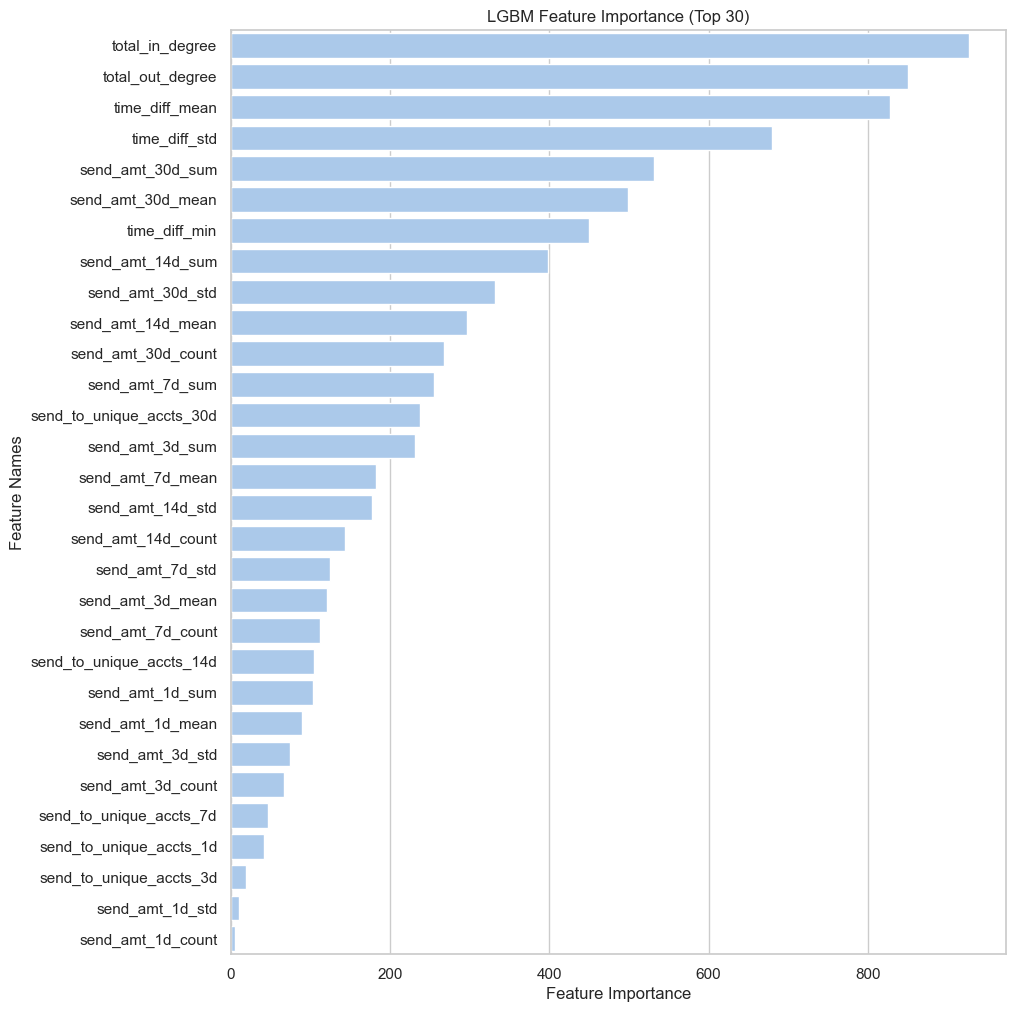


--- 產出提交檔案 ---

成功產出提交檔案: submission_final_v5.csv
預測為警示帳戶 (1) 的數量: 200
程式執行完畢。


In [15]:
print("\n--- 開始使用 Optuna 進行超參數優化 ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=CFG.OPTUNA_TRIALS, show_progress_bar=True)
best_params = study.best_params
print(f"找到的最佳參數組合: {best_params}")

# --- Final model training and prediction ---
print("\n--- 使用最佳參數進行最終模型訓練與預測 ---")
final_params = {**best_params, 'objective': 'binary', 'metric': 'auc', 'n_estimators': 10000, 'verbosity': -1, 'seed': CFG.RANDOM_SEED}
folds = StratifiedKFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.RANDOM_SEED)
oof_preds_proba = np.zeros(len(X))
sub_preds_proba = np.zeros(len(X_test_final))
feature_importances = pd.DataFrame(index=features_columns)  # 注意這裡用 features_columns

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]  # ← 修正這裡
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
    model = lgb.LGBMClassifier(**final_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(200, verbose=False)])
    oof_preds_proba[valid_idx] = model.predict_proba(X_valid)[:, 1]
    sub_preds_proba += model.predict_proba(X_test_final)[:, 1] / CFG.N_SPLITS
    feature_importances[f'fold_{n_fold+1}'] = model.feature_importances_
    print(f"Fold {n_fold+1} 完成。")

# --- Find the best threshold ---
#best_f1, best_threshold = 0, 0.5
#for threshold in np.arange(0.01, 0.51, 0.01):
#    current_f1 = f1_score(y, (oof_preds_proba > threshold).astype(int))
#    if current_f1 > best_f1:
#        best_f1, best_threshold = current_f1, threshold
        
#print(f"\n交叉驗證 F1-Score: {best_f1:.4f} (在最佳門檻值 {best_threshold:.2f} 時)")

# Plot feature importance
#feature_importances['average'] = feature_importances.mean(axis=1)
#plot_feature_importance(feature_importances['average'], X.columns)

# --- Generate submission file ---
#print("\n--- 產出提交檔案 ---")
#y_pred_final = (sub_preds_proba > best_threshold).astype(int)

# --- (找到最佳門檻值的 for 迴圈可以刪除或註解掉) ---
# ...

# Plot feature importance (這部分可以保留)
feature_importances['average'] = feature_importances.mean(axis=1)
plot_feature_importance(feature_importances['average'], X.columns)


# --- 產出提交檔案 (改用 Top N 策略) ---
print("\n--- 產出提交檔案 ---")

# 1. 定義要提交的數量 (可以從 150~250 開始嘗試)
TOP_N = 200

# 2. 建立一個包含帳戶 ID 和預測機率的 DataFrame
df_pred_proba = pd.DataFrame({
    'acct_id': X_test_final.index,
    'proba': sub_preds_proba
})

# 3. 根據機率降序排列，取出前 N 個帳戶的 ID
top_n_acct_ids = df_pred_proba.sort_values('proba', ascending=False).head(TOP_N)['acct_id']

# 4. 建立提交用的 DataFrame，只將 Top N 帳戶的 label 設為 1
df_submission = pd.DataFrame({'acct_id': X_test_final.index})
df_submission['label'] = 0
df_submission.loc[df_submission['acct_id'].isin(top_n_acct_ids), 'label'] = 1

# 5. 將 acct_id 轉回原始編碼並合併到 submission 模板
submission_accts_original = le_acct.inverse_transform(df_submission['acct_id'])
df_submission['acct'] = submission_accts_original

df_output = submission.merge(df_submission[['acct', 'label']], on='acct', how='left')
df_output.drop(columns=['label_x'], inplace=True, errors='ignore')
df_output.rename(columns={'label_y': 'label'}, inplace=True)
df_output['label'] = df_output['label'].fillna(0).astype(int)

# --- 後續存檔邏輯不變 ---
output_path = "submission_final_v5.csv" # 建議換個版本號
df_output.to_csv(output_path, index=False)

print(f"\n成功產出提交檔案: {output_path}")
print(f"預測為警示帳戶 (1) 的數量: {df_output['label'].sum()}")
print("程式執行完畢。")

#submission_acct_ids = X_test_final.index
#submission_accts_original = le_acct.inverse_transform(submission_acct_ids)

#df_submission = pd.DataFrame({'acct': submission_accts_original, 'label': y_pred_final})
#df_output = submission.merge(df_submission, on='acct', how='left')
#df_output.drop(columns=['label_x'], inplace=True, errors='ignore')
#df_output.rename(columns={'label_y': 'label'}, inplace=True)
#df_output['label'] = df_output['label'].fillna(0).astype(int)

#output_path = "submission_final_v4.csv"
#df_output.to_csv(output_path, index=False)

#print(f"\n成功產出提交檔案: {output_path}")
#print(f"預測為警示帳戶 (1) 的數量: {df_output['label'].sum()}")
#print("程式執行完畢。")